Now it's time to implement the modeling phase of the project. The goal is to predict whether a given cascade (reddit post or grouping of related reddit posts) will at least double in size when observed at a specific stage. To implement this, I will extract features from the connected components of the post graph at various stages (numbers of responding comments or posts).

In this analysis, I will focus exclusively on temporal features. This is because there is considerable evidence that temporal features alone perform relatively well for this prediction task (a paper by Leskovec et al will be referenced in the final report), and that other features (eg. structural) may bias the predictor against accurate predictions of the large GME cascade, because of the vastly different scale.

Therefore, my hope is that there is enough similarity in temporal cascade structure between smaller and larger cascades for this to provide good predictions.

I will test a number of machine learning algorithms in this section, so I will be importing a large number of libraries.

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pickle as pkl
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from rotation_forest import RotationForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score

I load the graphs created in the last section. Recall that one has some directed links between posts if they are on the same topic (stock) and were made by someone who commented on the parent post within 24 hours. The other simly contains post-comment cascades.

I will refer to cascades with a single source post as trees, and cascades with multiple source posts as forests, again taking my cue from Leskovec's paper.

In [2]:
graph = nx.read_gpickle(open('posts_graph_connected.pkl','rb'))

In [3]:
graph_trees = nx.read_gpickle(open('posts_graph_disconnected.pkl','rb'))

In terms of nodes and edges, there isn't noticeably much difference between the graphs.

In [4]:
len(graph.nodes())

2482046

In [5]:
len(graph_trees.nodes())

2482046

In [6]:
len(graph.edges())

2282869

In [7]:
len(graph_trees.edges())

2192225

First, I will graphically examine both the forest cascades and the tree cascades.

In [8]:
components_5 = [a for a in nx.weakly_connected_components(graph) if len(a) > 5]

In [9]:
graphs_list = []
for component in components_5:
    g = nx.subgraph(graph,component)
    graphs_list.append(g)

In [10]:
forest_list = []
trees_list = []
for g in graphs_list:
    nodes = [n for n in g.nodes(data=True) if n[1]['posttype'] == 'post']
    if len(nodes) > 4:
        #print(len(nodes))
        forest_list.append(g)
    if len(nodes) == 1:
        trees_list.append(g)

In [11]:
x_vals = []
for forest in forest_list:
    nodes = forest.nodes(data=True)
    sorted_nodes = sorted(nodes,key=lambda k:k[1]['time'])
    if len(sorted_nodes) > 5000:
        interval = sorted_nodes[-1][1]['time'] - sorted_nodes[0][1]['time']
        bin_size = int(np.floor(interval/1000))
        counts = []
        for i in range(1,1000):
            current_min = sorted_nodes[0][1]['time'] + (i-1)*bin_size 
            current_max = sorted_nodes[0][1]['time'] + (i)*bin_size
            current_count = 0
            for node in sorted_nodes:
                if node[1]['time'] > current_min and node[1]['time'] < current_max:
                    current_count += 1
            counts.append(current_count)
        x_vals.append(counts)
        #print(len(x_vals))

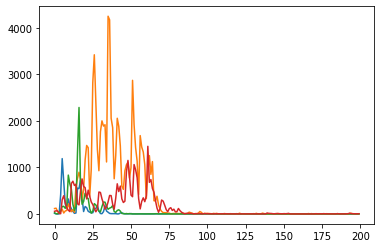

In [12]:
plt.plot(x_vals[0][:200])
plt.plot(x_vals[1][:200])
plt.plot(x_vals[2][:200])
plt.plot(x_vals[3][:200])

As can be seen above, forest cascades typically begin relatively small, but reach their peak quickly in their life cycle before mostly dying off.

Below, I have included a much larger cascade with the others above. Besides being significantly larger, it also peaked at a later relative time, which may make predicting forest cascades more challenging.

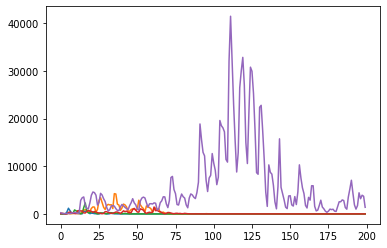

In [13]:
plt.plot(x_vals[0][:200])
plt.plot(x_vals[1][:200])
plt.plot(x_vals[2][:200])
plt.plot(x_vals[3][:200])
plt.plot(x_vals[4][:200])

The tree cascades, on the other hand, typically peak immediately, and drop off very fast. This makes intuitive sense, since they have only one root post, and popular posts on Reddit tend to become active very quickly.

In [14]:
x_vals_tree = []
for tree in trees_list:
    nodes = tree.nodes(data=True)
    sorted_nodes = sorted(nodes,key=lambda k:k[1]['time'])
    if len(sorted_nodes) > 500:
        interval = sorted_nodes[-1][1]['time'] - sorted_nodes[0][1]['time']
        bin_size = int(np.floor(interval/1000))
        counts = []
        for i in range(1,1000):
            current_min = sorted_nodes[0][1]['time'] + (i-1)*bin_size 
            current_max = sorted_nodes[0][1]['time'] + (i)*bin_size
            current_count = 0
            for node in sorted_nodes:
                if node[1]['time'] > current_min and node[1]['time'] < current_max:
                    current_count += 1
            counts.append(current_count)
        x_vals_tree.append(counts)
        #print(len(x_vals_tree))

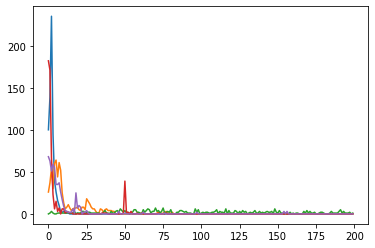

In [15]:
plt.plot(x_vals_tree[0][:200])
plt.plot(x_vals_tree[1][:200])
plt.plot(x_vals_tree[2][:200])
plt.plot(x_vals_tree[3][:200])
plt.plot(x_vals_tree[4][:200])

I will experiment with the graph of trees first, though predicting the forests is the more useful task in this instance, since it is large groupings of reddit posts that spawn the collective action resulting in events like the Gamestop stock explosion.

Here, I extract all weakly connected components of the tree graph. A weakly connected component is just a group of nodes, each of which are connected by undirected path.

In [16]:
components_100 = [a for a in nx.weakly_connected_components(graph_trees) if len(a) > 100]

In [17]:
len(components_100)

3990

Here, I split the trees into 5 separate 'folds' for cross validation in order to produce the most accurate model. I am performing this step here because I will be extracting multiple data rows from some of the trees to have more data available, and I don't want rows relating to the same trees being in both the training set and the test set, to ensure that my results aren't biased. However, this means that the sizes of the train and test sets won't always be the same for each fold.

In [18]:
tree_list = []
for component in components_100:
    g = nx.subgraph(graph_trees,component)
    tree_list.append(g)

In [19]:
random.shuffle(tree_list)

In [20]:
train_tree_folds = []
test_tree_folds = []

In [21]:
for i in range(5):
    test_trees = tree_list[int(np.floor(i*len(tree_list)/5)):int(np.floor((i+1)*len(tree_list)/5))]
    train_trees = tree_list
    train_trees = [t for t in train_trees if t not in test_trees]
    train_tree_folds.append(train_trees)
    test_tree_folds.append(test_trees)

In [22]:
len(test_tree_folds[0])

798

Now, I extract the temporal features relating to each tree. I iterate over all the trees in the training set for each fold, and calculate the various temporal features. The features are very simple, consisting of averages of the time it takes for a new node to be added at various intervals, and their ratios.

In [23]:
def extract_features_trees(folds):
    tree_features_list = []
    for k in range(5):    
        tree_features = pd.DataFrame()

        count = 0
        for tree in folds[k]:
            print(count)
            f = nx.DiGraph(tree)
            sorted_nodes = sorted([n for n in f.nodes(data=True)], key=lambda x: x[1]['time'])
            steps = [100 + i*100 for i in range(100)]

            for step in steps:
            #for step in [1000,1250,1500,1750,2000,3000,4000,5000,6000,7000,8000,9000,10000,12000,15000,17500,20000,22000,25000,30000,35000,40000,50000,60000,70000,80000,90000,100000,125000,150000,175000,200000]:
                if len(sorted_nodes) < step:
                    break
                count += 1
                if len(sorted_nodes) > 2*step:
                    result = 1
                else:
                    result = 0

                all_nodes_first_half = sorted_nodes[:int(np.floor(step/2))]
                all_nodes_second_half = sorted_nodes[int(np.floor(step/2)):step]

                avg_time_first_half_all = np.mean([all_nodes_first_half[i][1]['time'] - all_nodes_first_half[i-1][1]['time'] for i in range(1,len(all_nodes_first_half))])

                avg_time_second_half_all = np.mean([all_nodes_second_half[i][1]['time'] - all_nodes_second_half[i-1][1]['time'] for i in range(1,len(all_nodes_second_half))])
                #print(avg_time_second_half_all)
                ratio_all = avg_time_second_half_all / avg_time_first_half_all

                all_nodes_first_q = sorted_nodes[:int(np.floor(step/4))]
                all_nodes_second_q = sorted_nodes[int(np.floor(step/4)):int(2*np.floor(step/4))]
                all_nodes_third_q = sorted_nodes[int(2*np.floor(step/4)):int(3*np.floor(step/4))]
                all_nodes_fourth_q = sorted_nodes[int(3*np.floor(step/4)):step]

                avg_time_first_q_all = np.mean([all_nodes_first_q[i][1]['time'] - all_nodes_first_q[i-1][1]['time'] for i in range(1,len(all_nodes_first_q))])
                avg_time_second_q_all = np.mean([all_nodes_second_q[i][1]['time'] - all_nodes_second_q[i-1][1]['time'] for i in range(1,len(all_nodes_second_q))])
                avg_time_third_q_all = np.mean([all_nodes_third_q[i][1]['time'] - all_nodes_third_q[i-1][1]['time'] for i in range(1,len(all_nodes_third_q))])
                avg_time_fourth_q_all = np.mean([all_nodes_fourth_q[i][1]['time'] - all_nodes_fourth_q[i-1][1]['time'] for i in range(1,len(all_nodes_fourth_q))])
                ratio_43 = avg_time_fourth_q_all/avg_time_third_q_all
                ratio_42 = avg_time_fourth_q_all/avg_time_second_q_all
                ratio_41 = avg_time_fourth_q_all/avg_time_first_q_all

                all_nodes_first_10 = sorted_nodes[:int(np.floor(step/10))]
                all_nodes_second_10 = sorted_nodes[int(np.floor(step/10)):int(2*np.floor(step/10))]
                all_nodes_third_10 = sorted_nodes[int(2*np.floor(step/10)):int(3*np.floor(step/10))]
                all_nodes_fourth_10 = sorted_nodes[int(3*np.floor(step/10)):int(4*np.floor(step/10))]
                all_nodes_fifth_10 = sorted_nodes[int(4*np.floor(step/10)):int(5*np.floor(step/10))]
                all_nodes_sixth_10 = sorted_nodes[int(5*np.floor(step/10)):int(6*np.floor(step/10))]
                all_nodes_seventh_10 = sorted_nodes[int(6*np.floor(step/10)):int(7*np.floor(step/10))]
                all_nodes_eighth_10 = sorted_nodes[int(7*np.floor(step/10)):int(8*np.floor(step/10))]
                all_nodes_ninth_10 = sorted_nodes[int(8*np.floor(step/10)):int(9*np.floor(step/10))]
                all_nodes_last_10 = sorted_nodes[int(9*np.floor(step/10)):step]

                avg_time_first_10_all = np.mean([all_nodes_first_10[i][1]['time'] - all_nodes_first_10[i-1][1]['time'] for i in range(1,len(all_nodes_first_10))])
                avg_time_second_10_all = np.mean([all_nodes_second_10[i][1]['time'] - all_nodes_second_10[i-1][1]['time'] for i in range(1,len(all_nodes_second_10))])
                avg_time_third_10_all = np.mean([all_nodes_third_10[i][1]['time'] - all_nodes_third_10[i-1][1]['time'] for i in range(1,len(all_nodes_third_10))])
                avg_time_fourth_10_all = np.mean([all_nodes_fourth_10[i][1]['time'] - all_nodes_fourth_10[i-1][1]['time'] for i in range(1,len(all_nodes_fourth_10))])
                avg_time_fifth_10_all = np.mean([all_nodes_fifth_10[i][1]['time'] - all_nodes_fifth_10[i-1][1]['time'] for i in range(1,len(all_nodes_fifth_10))])
                avg_time_sixth_10_all = np.mean([all_nodes_sixth_10[i][1]['time'] - all_nodes_sixth_10[i-1][1]['time'] for i in range(1,len(all_nodes_sixth_10))])
                avg_time_seventh_10_all = np.mean([all_nodes_seventh_10[i][1]['time'] - all_nodes_seventh_10[i-1][1]['time'] for i in range(1,len(all_nodes_seventh_10))])
                avg_time_eighth_10_all = np.mean([all_nodes_eighth_10[i][1]['time'] - all_nodes_eighth_10[i-1][1]['time'] for i in range(1,len(all_nodes_eighth_10))])
                avg_time_ninth_10_all = np.mean([all_nodes_ninth_10[i][1]['time'] - all_nodes_ninth_10[i-1][1]['time'] for i in range(1,len(all_nodes_ninth_10))])
                avg_time_last_10_all = np.mean([all_nodes_last_10[i][1]['time'] - all_nodes_last_10[i-1][1]['time'] for i in range(1,len(all_nodes_last_10))])

                ratio_109 = avg_time_last_10_all/avg_time_ninth_10_all
                ratio_108 = avg_time_last_10_all/avg_time_eighth_10_all
                ratio_106 = avg_time_last_10_all/avg_time_sixth_10_all
                ratio_101 = avg_time_last_10_all/avg_time_first_10_all


                tree_features = tree_features.append({'avg_time_last_10_all':avg_time_last_10_all,'avg_time_ninth_10_all':avg_time_ninth_10_all,
                                                                  'avg_time_eighth_10_all':avg_time_eighth_10_all,'ratio_109':ratio_109,'ratio_108':ratio_108,'ratio_106':ratio_106,'ratio_101':ratio_101,'ratio_42':ratio_42,'ratio_41':ratio_41,'avg_time_first_half_all':avg_time_first_half_all,'avg_time_second_half_all':avg_time_second_half_all,
                                                'ratio_all':ratio_all,'avg_time_third_q_all':avg_time_third_q_all,'avg_time_fourth_q_all':avg_time_fourth_q_all,'ratio_43':ratio_43,'class':result},ignore_index=True)
        tree_features_list.append(tree_features)
    return tree_features_list

In [ ]:
train_tree_features_list = extract_features_trees(train_tree_folds)
test_tree_features_list = extract_features_trees(test_tree_folds)

In [249]:
pkl.dump(train_tree_features_list,open('train_tree_features_list.pkl','wb'))
pkl.dump(test_tree_features_list,open('test_tree_features_list.pkl','wb'))

In [25]:
train_tree_features_list = pkl.load(open('train_tree_features_list.pkl','rb'))
test_tree_features_list = pkl.load(open('test_tree_features_list.pkl','rb'))

I create a new column for the target variable so that it's at the end of the dataframe.

In [26]:
for i in range(5):
    train_tree_features_list[i]['result'] = train_tree_features_list[i]['class']
    train_tree_features_list[i] = train_tree_features_list[i].drop('class',axis=1)
    test_tree_features_list[i]['result'] = test_tree_features_list[i]['class']
    test_tree_features_list[i] = test_tree_features_list[i].drop('class',axis=1)

Now I will evaluate three different machine learning models, and tune their hyperparameters for the best result. I will use standard Logistic Regression, Random Forest, and XGBoost, a gradient boosting algorithm.

For Logistic Regression, I incorporate a scaler into the pipeline, since the model is linear.

I evaluate the model via both the accuracy score and the f1 score.

In [27]:
best_C_acc = 1
best_C_f1 = 1
best_accuracy = 0
best_f1 = 0

for C in [1,0.5,0.25,0.1,0.05,0.025,0.01]:
    av_accuracy = 0
    av_f1 = 0
    for i in range(5):
        X_train = train_tree_features_list[i].iloc[:,:-1]
        y_train = train_tree_features_list[i].iloc[:,-1]
        X_test = test_tree_features_list[i].iloc[:,:-1]
        y_test = test_tree_features_list[i].iloc[:,-1]
    
        xg = make_pipeline(StandardScaler(),LogisticRegression(C=C))
        xg.fit(X_train,y_train)
        y_pred = xg.predict(X_test)
        #print(f1_score(y_test,y_pred))
        #print(accuracy_score(y_pred,y_test))
        av_accuracy = av_accuracy + accuracy_score(y_test,y_pred)
        av_f1 = av_f1 + f1_score(y_test,y_pred)
    av_accuracy = av_accuracy/5
    av_f1 = av_f1/5
    if av_accuracy > best_accuracy:
        best_accuracy = av_accuracy
        best_C_acc = C
    if av_f1 > best_f1:
        best_f1 = av_f1
        best_C_f1 = C
print(best_C_acc)
print(best_accuracy)
print(best_C_f1)
print(best_f1)

1
0.7261593889600113
1
0.6649945355090651


In this case, the default C value of 1 produces the best results. Accuracy of about 0.72 and f1 of around 0.66.

Now, I evaluate the Random Forest, tuning two relevant hyperparameters, n_estimators and max_depth.

In [28]:
best_estimators_acc = [2,10]
best_estimators_f1 = [2,10]
best_accuracy = 0
best_f1 = 0
for max_depth in [2,3,4,5,6,7,8]:
    for n_estimators in [10,50,100,200,350,500,750,1000]:
        av_accuracy = 0
        av_f1 = 0
        for i in range(5):
            X_train = train_tree_features_list[i].iloc[:,:-1]
            y_train = train_tree_features_list[i].iloc[:,-1]
            X_test = test_tree_features_list[i].iloc[:,:-1]
            y_test = test_tree_features_list[i].iloc[:,-1]

            xg = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth)
            xg.fit(X_train,y_train)
            y_pred = xg.predict(X_test)
            #print(f1_score(y_test,y_pred))
            #print(accuracy_score(y_pred,y_test))
            av_accuracy = av_accuracy + accuracy_score(y_test,y_pred)
            av_f1 = av_f1 + f1_score(y_test,y_pred)
        av_accuracy = av_accuracy/5
        av_f1 = av_f1/5
        if av_accuracy > best_accuracy:
            best_accuracy = av_accuracy
            best_estimators_acc = [max_depth,n_estimators]
        if av_f1 > best_f1:
            best_f1 = av_f1
            best_estimators_f1 = [max_depth,n_estimators]
print(best_estimators_acc)
print(best_accuracy)
print(best_estimators_f1)
print(best_f1)

[8, 50]
0.7482550899085314
[8, 50]
0.6964148525462874


A max depth of 8 and n_estimators of 500 produced the best results for both metrics, improving on Logistic Regression.

In [ ]:
best_estimators_acc = [2,10]
best_estimators_f1 = [2,10]
best_accuracy = 0
best_f1 = 0
for max_depth in [2,3,4,5,6,7,8]:
    for n_estimators in [10,50,100,200,350,500,750,1000]:
        av_accuracy = 0
        av_f1 = 0
        for i in range(5):
            X_train = train_tree_features_list[i].iloc[:,:-1]
            y_train = train_tree_features_list[i].iloc[:,-1]
            X_test = test_tree_features_list[i].iloc[:,:-1]
            y_test = test_tree_features_list[i].iloc[:,-1]

            xg = XGBClassifier(n_estimators=n_estimators,max_depth=max_depth)
            xg.fit(X_train,y_train)
            y_pred = xg.predict(X_test)
            av_accuracy = av_accuracy + accuracy_score(y_test,y_pred)
            av_f1 = av_f1 + f1_score(y_test,y_pred)
        av_accuracy = av_accuracy/5
        av_f1 = av_f1/5
        if av_accuracy > best_accuracy:
            best_accuracy = av_accuracy
            best_estimators_acc = [max_depth,n_estimators]
        if av_f1 > best_f1:
            best_f1 = av_f1
            best_estimators_f1 = [max_depth,n_estimators]
print(best_estimators_acc)
print(best_accuracy)
print(best_estimators_f1)
print(best_f1)

XGBoost produces very similar results to the Random Forest, though interestingly its best performance was at very low parameter values.

Here, the results are displayed graphically.

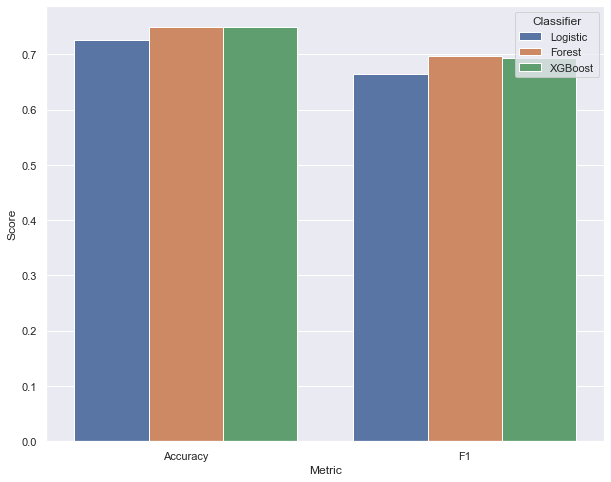

In [19]:
sns.set(rc={'figure.figsize':(10,8)})

results = pd.DataFrame()
results = results.append([{'Classifier':'Logistic','Score':0.726,'Metric':'Accuracy'},
                        {'Classifier':'Logistic','Score':0.665,'Metric':'F1'},
                        {'Classifier':'Forest','Score':0.749,'Metric':'Accuracy'},
                        {'Classifier':'Forest','Score':0.697,'Metric':'F1'},
                        {'Classifier':'XGBoost','Score':0.749,'Metric':'Accuracy'},
                        {'Classifier':'XGBoost','Score':0.693,'Metric':'F1'}])


stx = sns.barplot(x='Metric',y='Score',hue='Classifier',data=results)

Now, I perform very similar steps to those above, but on the cascade forest graph.

In [3]:
components_100 = [a for a in nx.weakly_connected_components(graph) if len(a) > 100]

In [4]:
len(components_100)

1295

In [5]:
graphs_list = []
for component in components_100:
    g = nx.subgraph(graph,component)
    graphs_list.append(g)

In [ ]:
forest_list = []
trees_list = []
for g in graphs_list:
    nodes = [n for n in g.nodes(data=True) if n[1]['posttype'] == 'post']
    if len(nodes) > 4:
        print(len(nodes))
        forest_list.append(g)
    if len(nodes) == 1:
        trees_list.append(g)

After filtering for forests with at least 100 nodes, and at least 5 parent nodes (original posts), the list is far smaller than that of the trees, with only 167 entries.

In [7]:
len(forest_list)

167

I sort the forest list and extract the largest (GME) cascade, consisting of 36695 original posts and over a million nodes.

I then sort the data into folds, as before.

In [7]:
forest_list_sorted = sorted(forest_list,key=lambda k: len(k.nodes()),reverse=True)

In [8]:
gme_forest = forest_list_sorted[0]

In [10]:
train_forests = []
test_forests = []
for i in range(1,len(forest_list_sorted)):
    if random.random() > 0.2:
        train_forests.append(forest_list_sorted[i])
    else:
        test_forests.append(forest_list_sorted[i])

In [10]:
forests_shuffled = forest_list_sorted[1:]

In [11]:
random.shuffle(forests_shuffled)

In [12]:
print(len(forests_shuffled[0].nodes()))

314


In [13]:
train_forest_folds = []
test_forest_folds = []

In [14]:
for i in range(5):
    test_forest = forests_shuffled[int(np.floor(i*len(forests_shuffled)/5)):int(np.floor((i+1)*len(forests_shuffled)/5))]
    train_forest = forests_shuffled
    train_forest = [t for t in train_forest if t not in test_forest]
    train_forest_folds.append(train_forest)
    test_forest_folds.append(test_forest)

In [15]:
len(train_forest_folds[0])

133

In [11]:
len(train_forests)

132

For the forests, I take some additional temporal features into account, including the time between posts (as opposed to all nodes), and the average time for new nodes to be added for the most quickly expanding tree within the forest.

In [4]:
def extract_features_forests(folds,start,step,step_range):
    forest_features_list = []
    for k in range(5):    
        features = pd.DataFrame()

        count = 0
        for forest in folds[k]:
            print(count)
            f = nx.DiGraph(forest)
            sorted_nodes = sorted([n for n in f.nodes(data=True)], key=lambda x: x[1]['time'])
            steps = [start + i*step for i in range(step_range)]

            for step in steps:
            #for step in [1000,1250,1500,1750,2000,3000,4000,5000,6000,7000,8000,9000,10000,12000,15000,17500,20000,22000,25000,30000,35000,40000,50000,60000,70000,80000,90000,100000,125000,150000,175000,200000]:
                if len(sorted_nodes) < step:
                    break
                count += 1
                if len(sorted_nodes) > 2*step:
                    result = 1
                else:
                    result = 0
                f_step = nx.DiGraph(nx.subgraph(f,[n[0] for n in sorted_nodes[:step]]))
                f_step_d = nx.DiGraph(nx.subgraph(f,[n[0] for n in sorted_nodes[:step]]))
                posts = [n for n in f_step.nodes(data=True) if n[1]['posttype'] == 'post']

                sorted_posts = sorted(posts,key=lambda k: k[1]['time'])
                if len(sorted_posts) == 1:
                    time_between_posts = None
                    time_between_latest_posts = None
                else:
                    time_between_posts = np.mean([sorted_posts[i][1]['time'] - sorted_posts[i-1][1]['time'] for i in range(1,len(sorted_posts))])
                    time_between_latest_posts = sorted_posts[-1][1]['time'] - sorted_posts[-2][1]['time']
                for post1 in posts:
                    for post2 in posts:
                        if f_step_d.has_edge(post1[0],post2[0]):
                            f_step_d.remove_edge(post1[0],post2[0])

                all_nodes_first_half = sorted_nodes[:int(np.floor(step/2))]
                all_nodes_second_half = sorted_nodes[int(np.floor(step/2)):step]

                avg_time_first_half_all = np.mean([all_nodes_first_half[i][1]['time'] - all_nodes_first_half[i-1][1]['time'] for i in range(1,len(all_nodes_first_half))])

                avg_time_second_half_all = np.mean([all_nodes_second_half[i][1]['time'] - all_nodes_second_half[i-1][1]['time'] for i in range(1,len(all_nodes_second_half))])
                print(avg_time_second_half_all)
                ratio_all = avg_time_second_half_all / avg_time_first_half_all

                all_nodes_first_q = sorted_nodes[:int(np.floor(step/4))]
                all_nodes_second_q = sorted_nodes[int(np.floor(step/4)):int(2*np.floor(step/4))]
                all_nodes_third_q = sorted_nodes[int(2*np.floor(step/4)):int(3*np.floor(step/4))]
                all_nodes_fourth_q = sorted_nodes[int(3*np.floor(step/4)):step]

                avg_time_first_q_all = np.mean([all_nodes_first_q[i][1]['time'] - all_nodes_first_q[i-1][1]['time'] for i in range(1,len(all_nodes_first_q))])
                avg_time_second_q_all = np.mean([all_nodes_second_q[i][1]['time'] - all_nodes_second_q[i-1][1]['time'] for i in range(1,len(all_nodes_second_q))])
                avg_time_third_q_all = np.mean([all_nodes_third_q[i][1]['time'] - all_nodes_third_q[i-1][1]['time'] for i in range(1,len(all_nodes_third_q))])
                avg_time_fourth_q_all = np.mean([all_nodes_fourth_q[i][1]['time'] - all_nodes_fourth_q[i-1][1]['time'] for i in range(1,len(all_nodes_fourth_q))])
                ratio_43 = avg_time_fourth_q_all/avg_time_third_q_all
                ratio_42 = avg_time_fourth_q_all/avg_time_second_q_all
                ratio_41 = avg_time_fourth_q_all/avg_time_first_q_all

                all_nodes_first_10 = sorted_nodes[:int(np.floor(step/10))]
                all_nodes_second_10 = sorted_nodes[int(np.floor(step/10)):int(2*np.floor(step/10))]
                all_nodes_third_10 = sorted_nodes[int(2*np.floor(step/10)):int(3*np.floor(step/10))]
                all_nodes_fourth_10 = sorted_nodes[int(3*np.floor(step/10)):int(4*np.floor(step/10))]
                all_nodes_fifth_10 = sorted_nodes[int(4*np.floor(step/10)):int(5*np.floor(step/10))]
                all_nodes_sixth_10 = sorted_nodes[int(5*np.floor(step/10)):int(6*np.floor(step/10))]
                all_nodes_seventh_10 = sorted_nodes[int(6*np.floor(step/10)):int(7*np.floor(step/10))]
                all_nodes_eighth_10 = sorted_nodes[int(7*np.floor(step/10)):int(8*np.floor(step/10))]
                all_nodes_ninth_10 = sorted_nodes[int(8*np.floor(step/10)):int(9*np.floor(step/10))]
                all_nodes_last_10 = sorted_nodes[int(9*np.floor(step/10)):step]

                avg_time_first_10_all = np.mean([all_nodes_first_10[i][1]['time'] - all_nodes_first_10[i-1][1]['time'] for i in range(1,len(all_nodes_first_10))])
                avg_time_second_10_all = np.mean([all_nodes_second_10[i][1]['time'] - all_nodes_second_10[i-1][1]['time'] for i in range(1,len(all_nodes_second_10))])
                avg_time_third_10_all = np.mean([all_nodes_third_10[i][1]['time'] - all_nodes_third_10[i-1][1]['time'] for i in range(1,len(all_nodes_third_10))])
                avg_time_fourth_10_all = np.mean([all_nodes_fourth_10[i][1]['time'] - all_nodes_fourth_10[i-1][1]['time'] for i in range(1,len(all_nodes_fourth_10))])
                avg_time_fifth_10_all = np.mean([all_nodes_fifth_10[i][1]['time'] - all_nodes_fifth_10[i-1][1]['time'] for i in range(1,len(all_nodes_fifth_10))])
                avg_time_sixth_10_all = np.mean([all_nodes_sixth_10[i][1]['time'] - all_nodes_sixth_10[i-1][1]['time'] for i in range(1,len(all_nodes_sixth_10))])
                avg_time_seventh_10_all = np.mean([all_nodes_seventh_10[i][1]['time'] - all_nodes_seventh_10[i-1][1]['time'] for i in range(1,len(all_nodes_seventh_10))])
                avg_time_eighth_10_all = np.mean([all_nodes_eighth_10[i][1]['time'] - all_nodes_eighth_10[i-1][1]['time'] for i in range(1,len(all_nodes_eighth_10))])
                avg_time_ninth_10_all = np.mean([all_nodes_ninth_10[i][1]['time'] - all_nodes_ninth_10[i-1][1]['time'] for i in range(1,len(all_nodes_ninth_10))])
                avg_time_last_10_all = np.mean([all_nodes_last_10[i][1]['time'] - all_nodes_last_10[i-1][1]['time'] for i in range(1,len(all_nodes_last_10))])

                ratio_109 = avg_time_last_10_all/avg_time_ninth_10_all
                ratio_108 = avg_time_last_10_all/avg_time_eighth_10_all
                ratio_106 = avg_time_last_10_all/avg_time_sixth_10_all
                ratio_101 = avg_time_last_10_all/avg_time_first_10_all


                comps = [a for a in nx.weakly_connected_components(f_step_d)]
                temp_list = []
                for component in comps:
                    g = nx.subgraph(f_step_d,component)
                    temp_list.append(g)
                max_graph_size = 0
                avg_graph_size = 0
                for g in temp_list:
                    if len(g.nodes()) > max_graph_size:
                        max_graph_size = len(g.nodes())
                    avg_graph_size = avg_graph_size + len(g.nodes())
                avg_graph_size = avg_graph_size/len(temp_list)
                num_trees = len(temp_list)

                avg_time_all_graphs = 0
                avg_time_fastest_graph = 500000
                avg_time_fastest_graph_first_half = 500000
                avg_time_fastest_graph_second_half = 500000
                fastest_ratio = 1
                graphcount = 0
                for g in temp_list:
                    if len(g) < 4:
                        continue
                    graphcount += 1
                    sorted_nodes_g = sorted([n for n in g.nodes(data=True)], key=lambda x: x[1]['time'])
                    avg_time_g = np.mean([sorted_nodes_g[i][1]['time'] - sorted_nodes_g[i-1][1]['time'] for i in range(1,len(sorted_nodes_g))])
                    #print(avg_time_g)
                    if avg_time_fastest_graph > avg_time_g:
                        avg_time_fastest_graph = avg_time_g
                    avg_time_all_graphs += avg_time_g
                    sorted_nodes_first_half = sorted_nodes_g[:int(np.floor(len(sorted_nodes_g)/2))]
                    avg_time_first_half_g = np.mean([sorted_nodes_first_half[i][1]['time'] - sorted_nodes_first_half[i-1][1]['time'] for i in range(1,len(sorted_nodes_first_half))])

                    sorted_nodes_second_half = sorted_nodes_g[int(np.floor(len(sorted_nodes_g)/2)):]
                    avg_time_second_half_g = np.mean([sorted_nodes_second_half[i][1]['time'] - sorted_nodes_second_half[i-1][1]['time'] for i in range(1,len(sorted_nodes_second_half))])
                    if avg_time_fastest_graph_second_half > avg_time_second_half_g:
                        avg_time_fastest_graph_second_half = avg_time_second_half_g
                        avg_time_fastest_graph_first_half = avg_time_first_half_g
                        fastest_ratio = avg_time_fastest_graph_second_half/avg_time_fastest_graph_first_half
                avg_time_all_graphs = avg_time_all_graphs/graphcount
                num_active_trees = graphcount
                ratio_active_trees = graphcount/len(temp_list)
                ratio_avg_graph_size = avg_graph_size/step
                ratio_max_graph_size = max_graph_size/step

                if len(sorted_nodes) > 200000:
                    continue
                    #gme_forest = gme_forest.append({'ratio_42':ratio_42,'ratio_41':ratio_41,'avg_time_first_half_all':avg_time_first_half_all,'avg_time_second_half_all':avg_time_second_half_all,
                       #                             'ratio_all':ratio_all,'avg_time_third_q_all':avg_time_third_q_all,'avg_time_fourth_q_all':avg_time_fourth_q_all,'ratio_43':ratio_43,
                        #'ratio_avg_graph_size':ratio_avg_graph_size,'ratio_max_graph_size':ratio_max_graph_size,'num_nodes':step,'num_trees':num_trees,'avg_graph_size':avg_graph_size,'max_graph_size':max_graph_size,'avg_time_all_graphs':avg_time_all_graphs,
                                               #    'avg_time_fastest_graph':avg_time_fastest_graph,'avg_time_fastest_graph_first_half':avg_time_fastest_graph_first_half,
                                                 #  'avg_time_fastest_graph_second_half':avg_time_fastest_graph_second_half,'fastest_ratio':fastest_ratio,'num_active_trees':num_active_trees,
                                                  # 'ratio_active_trees':ratio_active_trees,'time_between_posts':time_between_posts,'time_between_latest_posts':time_between_latest_posts,'class':result},ignore_index=True)
                else:
                    features = features.append({'avg_time_last_10_all':avg_time_last_10_all,'avg_time_ninth_10_all':avg_time_ninth_10_all,
                                                                  'avg_time_eighth_10_all':avg_time_eighth_10_all,'ratio_109':ratio_109,'ratio_108':ratio_108,'ratio_106':ratio_106,'ratio_101':ratio_101,
                        'ratio_42':ratio_42,'ratio_41':ratio_41,'avg_time_first_half_all':avg_time_first_half_all,'avg_time_second_half_all':avg_time_second_half_all,
                                                    'ratio_all':ratio_all,'avg_time_third_q_all':avg_time_third_q_all,'avg_time_fourth_q_all':avg_time_fourth_q_all,'ratio_43':ratio_43,
                        'avg_time_all_graphs':avg_time_all_graphs,
                                                   'avg_time_fastest_graph':avg_time_fastest_graph,'avg_time_fastest_graph_first_half':avg_time_fastest_graph_first_half,
                                                   'avg_time_fastest_graph_second_half':avg_time_fastest_graph_second_half,'fastest_ratio':fastest_ratio,
                                                   'time_between_posts':time_between_posts,'time_between_latest_posts':time_between_latest_posts,'class':result},ignore_index=True)

        forest_features_list.append(features)
    return forest_features_list

In [ ]:
train_forest_features_list = extract_features_forests(train_forest_folds,100,100,600)
pkl.dump(train_forest_features_list,open('train_forest_features_list.pkl','wb'))

In [ ]:
pkl.dump(train_forest_features_list,open('train_forest_features_list.pkl','wb'))

In [18]:
test_forest_features_list = extract_features_forests(test_forest_folds,100,100,600)

In [ ]:
pkl.dump(test_forest_features_list,open('test_forest_features_list.pkl','wb'))

In [ ]:
gme_features = pd.DataFrame()

count = 0
gme_list = []
gme_list.append(gme_forest)
for forest in gme_list:
    print(count)
    f = forest
    sorted_nodes = sorted([n for n in f.nodes(data=True)], key=lambda x: x[1]['time'])
    if len(sorted_nodes) < 500000:
        continue
    steps = [10000 + i*10000 for i in range(80)]
    
    for step in steps:
    #for step in [1000,1250,1500,1750,2000,3000,4000,5000,6000,7000,8000,9000,10000,12000,15000,17500,20000,22000,25000,30000,35000,40000,50000,60000,70000,80000,90000,100000,125000,150000,175000,200000]:
        if len(sorted_nodes) < step:
            break
        count += 1
        if len(sorted_nodes) > 2*step:
            result = 1
        else:
            result = 0
        f_step = nx.DiGraph(nx.subgraph(f,[n[0] for n in sorted_nodes[:step]]))
        f_step_d = nx.DiGraph(nx.subgraph(f,[n[0] for n in sorted_nodes[:step]]))
        posts = [n for n in f_step.nodes(data=True) if n[1]['posttype'] == 'post']
        
        sorted_posts = sorted(posts,key=lambda k: k[1]['time'])
        if len(sorted_posts) == 1:
            time_between_posts = None
            time_between_latest_posts = None
        else:
            time_between_posts = np.mean([sorted_posts[i][1]['time'] - sorted_posts[i-1][1]['time'] for i in range(1,len(sorted_posts))])
            time_between_latest_posts = sorted_posts[-1][1]['time'] - sorted_posts[-2][1]['time']
        for post1 in posts:
            for post2 in posts:
                if f_step_d.has_edge(post1[0],post2[0]):
                    f_step_d.remove_edge(post1[0],post2[0])
                    
        all_nodes_first_half = sorted_nodes[:int(np.floor(step/2))]
        all_nodes_second_half = sorted_nodes[int(np.floor(step/2)):step]
        
        avg_time_first_half_all = np.mean([all_nodes_first_half[i][1]['time'] - all_nodes_first_half[i-1][1]['time'] for i in range(1,len(all_nodes_first_half))])
        
        avg_time_second_half_all = np.mean([all_nodes_second_half[i][1]['time'] - all_nodes_second_half[i-1][1]['time'] for i in range(1,len(all_nodes_second_half))])
        print(avg_time_second_half_all)
        ratio_all = avg_time_second_half_all / avg_time_first_half_all
        
        all_nodes_first_q = sorted_nodes[:int(np.floor(step/4))]
        all_nodes_second_q = sorted_nodes[int(np.floor(step/4)):int(2*np.floor(step/4))]
        all_nodes_third_q = sorted_nodes[int(2*np.floor(step/4)):int(3*np.floor(step/4))]
        all_nodes_fourth_q = sorted_nodes[int(3*np.floor(step/4)):step]
        
        avg_time_first_q_all = np.mean([all_nodes_first_q[i][1]['time'] - all_nodes_first_q[i-1][1]['time'] for i in range(1,len(all_nodes_first_q))])
        avg_time_second_q_all = np.mean([all_nodes_second_q[i][1]['time'] - all_nodes_second_q[i-1][1]['time'] for i in range(1,len(all_nodes_second_q))])
        avg_time_third_q_all = np.mean([all_nodes_third_q[i][1]['time'] - all_nodes_third_q[i-1][1]['time'] for i in range(1,len(all_nodes_third_q))])
        avg_time_fourth_q_all = np.mean([all_nodes_fourth_q[i][1]['time'] - all_nodes_fourth_q[i-1][1]['time'] for i in range(1,len(all_nodes_fourth_q))])
        ratio_43 = avg_time_fourth_q_all/avg_time_third_q_all
        ratio_42 = avg_time_fourth_q_all/avg_time_second_q_all
        ratio_41 = avg_time_fourth_q_all/avg_time_first_q_all
        
        all_nodes_first_10 = sorted_nodes[:int(np.floor(step/10))]
        all_nodes_second_10 = sorted_nodes[int(np.floor(step/10)):int(2*np.floor(step/10))]
        all_nodes_third_10 = sorted_nodes[int(2*np.floor(step/10)):int(3*np.floor(step/10))]
        all_nodes_fourth_10 = sorted_nodes[int(3*np.floor(step/10)):int(4*np.floor(step/10))]
        all_nodes_fifth_10 = sorted_nodes[int(4*np.floor(step/10)):int(5*np.floor(step/10))]
        all_nodes_sixth_10 = sorted_nodes[int(5*np.floor(step/10)):int(6*np.floor(step/10))]
        all_nodes_seventh_10 = sorted_nodes[int(6*np.floor(step/10)):int(7*np.floor(step/10))]
        all_nodes_eighth_10 = sorted_nodes[int(7*np.floor(step/10)):int(8*np.floor(step/10))]
        all_nodes_ninth_10 = sorted_nodes[int(8*np.floor(step/10)):int(9*np.floor(step/10))]
        all_nodes_last_10 = sorted_nodes[int(9*np.floor(step/10)):step]
                                                                       
        avg_time_first_10_all = np.mean([all_nodes_first_10[i][1]['time'] - all_nodes_first_10[i-1][1]['time'] for i in range(1,len(all_nodes_first_10))])
        avg_time_second_10_all = np.mean([all_nodes_second_10[i][1]['time'] - all_nodes_second_10[i-1][1]['time'] for i in range(1,len(all_nodes_second_10))])
        avg_time_third_10_all = np.mean([all_nodes_third_10[i][1]['time'] - all_nodes_third_10[i-1][1]['time'] for i in range(1,len(all_nodes_third_10))])
        avg_time_fourth_10_all = np.mean([all_nodes_fourth_10[i][1]['time'] - all_nodes_fourth_10[i-1][1]['time'] for i in range(1,len(all_nodes_fourth_10))])
        avg_time_fifth_10_all = np.mean([all_nodes_fifth_10[i][1]['time'] - all_nodes_fifth_10[i-1][1]['time'] for i in range(1,len(all_nodes_fifth_10))])
        avg_time_sixth_10_all = np.mean([all_nodes_sixth_10[i][1]['time'] - all_nodes_sixth_10[i-1][1]['time'] for i in range(1,len(all_nodes_sixth_10))])
        avg_time_seventh_10_all = np.mean([all_nodes_seventh_10[i][1]['time'] - all_nodes_seventh_10[i-1][1]['time'] for i in range(1,len(all_nodes_seventh_10))])
        avg_time_eighth_10_all = np.mean([all_nodes_eighth_10[i][1]['time'] - all_nodes_eighth_10[i-1][1]['time'] for i in range(1,len(all_nodes_eighth_10))])
        avg_time_ninth_10_all = np.mean([all_nodes_ninth_10[i][1]['time'] - all_nodes_ninth_10[i-1][1]['time'] for i in range(1,len(all_nodes_ninth_10))])
        avg_time_last_10_all = np.mean([all_nodes_last_10[i][1]['time'] - all_nodes_last_10[i-1][1]['time'] for i in range(1,len(all_nodes_last_10))])
        
        ratio_109 = avg_time_last_10_all/avg_time_ninth_10_all
        ratio_108 = avg_time_last_10_all/avg_time_eighth_10_all
        ratio_106 = avg_time_last_10_all/avg_time_sixth_10_all
        ratio_101 = avg_time_last_10_all/avg_time_first_10_all
                    
        
        comps = [a for a in nx.weakly_connected_components(f_step_d)]
        temp_list = []
        for component in comps:
            g = nx.subgraph(f_step_d,component)
            temp_list.append(g)
        max_graph_size = 0
        avg_graph_size = 0
        for g in temp_list:
            if len(g.nodes()) > max_graph_size:
                max_graph_size = len(g.nodes())
            avg_graph_size = avg_graph_size + len(g.nodes())
        avg_graph_size = avg_graph_size/len(temp_list)
        num_trees = len(temp_list)
        
        avg_time_all_graphs = 0
        avg_time_fastest_graph = 500000
        avg_time_fastest_graph_first_half = 500000
        avg_time_fastest_graph_second_half = 500000
        fastest_ratio = 1
        graphcount = 0
        for g in temp_list:
            if len(g) < 4:
                continue
            graphcount += 1
            sorted_nodes_g = sorted([n for n in g.nodes(data=True)], key=lambda x: x[1]['time'])
            avg_time_g = np.mean([sorted_nodes_g[i][1]['time'] - sorted_nodes_g[i-1][1]['time'] for i in range(1,len(sorted_nodes_g))])
            #print(avg_time_g)
            if avg_time_fastest_graph > avg_time_g:
                avg_time_fastest_graph = avg_time_g
            avg_time_all_graphs += avg_time_g
            sorted_nodes_first_half = sorted_nodes_g[:int(np.floor(len(sorted_nodes_g)/2))]
            avg_time_first_half_g = np.mean([sorted_nodes_first_half[i][1]['time'] - sorted_nodes_first_half[i-1][1]['time'] for i in range(1,len(sorted_nodes_first_half))])
            
            sorted_nodes_second_half = sorted_nodes_g[int(np.floor(len(sorted_nodes_g)/2)):]
            avg_time_second_half_g = np.mean([sorted_nodes_second_half[i][1]['time'] - sorted_nodes_second_half[i-1][1]['time'] for i in range(1,len(sorted_nodes_second_half))])
            if avg_time_fastest_graph_second_half > avg_time_second_half_g:
                avg_time_fastest_graph_second_half = avg_time_second_half_g
                avg_time_fastest_graph_first_half = avg_time_first_half_g
                fastest_ratio = avg_time_fastest_graph_second_half/avg_time_fastest_graph_first_half
        avg_time_all_graphs = avg_time_all_graphs/graphcount
        num_active_trees = graphcount
        ratio_active_trees = graphcount/len(temp_list)
        ratio_avg_graph_size = avg_graph_size/step
        ratio_max_graph_size = max_graph_size/step
        
        if len(sorted_nodes) > 500000:
            gme_features = gme_features.append({'avg_time_last_10_all':avg_time_last_10_all,'avg_time_ninth_10_all':avg_time_ninth_10_all,
                                                          'avg_time_eighth_10_all':avg_time_eighth_10_all,'ratio_109':ratio_109,'ratio_108':ratio_108,'ratio_106':ratio_106,'ratio_101':ratio_101,
                'ratio_42':ratio_42,'ratio_41':ratio_41,'avg_time_first_half_all':avg_time_first_half_all,'avg_time_second_half_all':avg_time_second_half_all,
                                            'ratio_all':ratio_all,'avg_time_third_q_all':avg_time_third_q_all,'avg_time_fourth_q_all':avg_time_fourth_q_all,'ratio_43':ratio_43,
                'avg_time_all_graphs':avg_time_all_graphs,
                                           'avg_time_fastest_graph':avg_time_fastest_graph,'avg_time_fastest_graph_first_half':avg_time_fastest_graph_first_half,
                                           'avg_time_fastest_graph_second_half':avg_time_fastest_graph_second_half,'fastest_ratio':fastest_ratio,
                                           'time_between_posts':time_between_posts,'time_between_latest_posts':time_between_latest_posts,'class':result},ignore_index=True)

In [10]:
gme_features.to_csv('gme_features.csv')

In [11]:
train_forest_features_list = pkl.load(open('train_forest_features_list.pkl','rb'))
test_forest_features_list = pkl.load(open('test_forest_features_list.pkl','rb'))

The train and test sets are a lot smaller than for the tree data, but a much more respectable size than before, after extracting multiple data points for each forest.

In [142]:
print(train_forest_features_list[0].shape)
print(test_forest_features_list[0].shape)

(3143, 23)
(322, 23)


I fill possible NaN values for two of the features with the column means.

In [12]:
for i in range(5):
    train_forest_features_list[i]['time_between_latest_posts'].fillna(value=train_forest_features_list[i]['time_between_latest_posts'].mean(), inplace=True)
    train_forest_features_list[i]['time_between_posts'].fillna(value=train_forest_features_list[i]['time_between_posts'].mean(), inplace=True)
    test_forest_features_list[i]['time_between_latest_posts'].fillna(value=test_forest_features_list[i]['time_between_latest_posts'].mean(), inplace=True)
    test_forest_features_list[i]['time_between_posts'].fillna(value=test_forest_features_list[i]['time_between_posts'].mean(), inplace=True)

In [13]:
for i in range(5):
    train_forest_features_list[i]['result'] = train_forest_features_list[i]['class']
    train_forest_features_list[i] = train_forest_features_list[i].drop('class',axis=1)
    test_forest_features_list[i]['result'] = test_forest_features_list[i]['class']
    test_forest_features_list[i] = test_forest_features_list[i].drop('class',axis=1)

In [47]:
gme_features = pd.read_csv('gme_features.csv',index_col=0)

In [117]:
gme_features

,avg_time_all_graphs,avg_time_eighth_10_all,avg_time_fastest_graph,avg_time_fastest_graph_first_half,avg_time_fastest_graph_second_half,avg_time_first_half_all,avg_time_fourth_q_all,avg_time_last_10_all,avg_time_ninth_10_all,avg_time_second_half_all,...,ratio_106,ratio_108,ratio_109,ratio_41,ratio_42,ratio_43,ratio_all,time_between_latest_posts,time_between_posts,result
0,487.047191,4.506507,5.904011,3.905172,7.885387,37.414683,3.467387,2.939940,3.411411,3.588518,...,0.915809,0.652377,0.861796,0.048054,1.290010,0.934433,0.095912,228.0,832.975610,1.0
1,944.327793,12.462731,21.760000,32.250000,12.916667,20.500850,5.820164,3.941471,5.449725,6.875288,...,0.832435,0.316261,0.723242,0.155558,1.621885,0.733796,0.335366,8.0,598.875274,1.0
2,819.063526,3.117372,17.659692,56.000000,11.000000,16.310621,2.910521,2.899633,2.915639,3.907527,...,0.410111,0.930153,0.994511,0.111174,0.451697,0.593436,0.239569,53.0,443.982430,1.0
3,873.487892,2.855464,17.602778,56.000000,11.000000,13.687634,4.548755,5.725681,4.194549,3.750038,...,1.897489,2.005167,1.365029,0.221881,0.661609,1.541117,0.273973,344.0,392.249719,1.0
4,851.330650,5.805561,21.000000,56.000000,11.000000,11.539782,3.596128,3.697339,3.119624,3.774191,...,1.251557,0.636862,1.185188,0.206083,0.638702,0.909842,0.327059,101.0,323.297297,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,1443.593312,0.806208,4.908449,66.000000,0.000000,3.717962,0.672961,0.712207,0.444927,0.624299,...,0.842876,0.883403,1.600728,0.110701,0.495977,1.169099,0.167914,12.0,61.885384,0.0
76,1468.355037,0.798816,5.189719,66.000000,0.000000,3.686272,0.656954,0.711503,0.448564,0.611854,...,0.925798,0.890697,1.586178,0.108517,0.498209,1.159169,0.165982,129.0,61.695984,0.0
77,1480.561209,0.795664,4.792653,66.000000,0.000000,3.649463,0.627372,0.702317,0.444454,0.605394,...,0.971018,0.882680,1.580177,0.104191,0.491057,1.075367,0.165886,36.0,61.420973,0.0
78,1502.864086,0.790111,2.975531,66.000000,0.000000,3.608470,0.579922,0.694680,0.434259,0.603219,...,0.985526,0.879218,1.599691,0.096695,0.475545,0.925662,0.167168,1.0,61.098869,0.0


In [14]:
gme_features['time_between_latest_posts'].fillna(value=gme_features['time_between_latest_posts'].mean(), inplace=True)
gme_features['time_between_posts'].fillna(value=gme_features['time_between_posts'].mean(), inplace=True)

In [15]:
gme_features['result'] = gme_features['class']
gme_features = gme_features.drop('class',axis=1)

Aa before, I iterate over the data using the three different machine learning models.

In [128]:
best_C_acc = 1
best_C_f1 = 1
best_accuracy = 0
best_f1 = 0

for C in [1,0.5,0.25,0.1,0.05,0.025,0.01]:
    av_accuracy = 0
    av_f1 = 0
    for i in range(5):
        X_train = train_forest_features_list[i].iloc[:,:-1]
        y_train = train_forest_features_list[i].iloc[:,-1]
        X_test = test_forest_features_list[i].iloc[:,:-1]
        y_test = test_forest_features_list[i].iloc[:,-1]
    
        xg = make_pipeline(StandardScaler(),LogisticRegression(C=C))
        xg.fit(X_train,y_train)
        y_pred = xg.predict(X_test)
        #print(f1_score(y_test,y_pred))
        #print(accuracy_score(y_pred,y_test))
        av_accuracy = av_accuracy + accuracy_score(y_test,y_pred)
        av_f1 = av_f1 + f1_score(y_test,y_pred)
    av_accuracy = av_accuracy/5
    av_f1 = av_f1/5
    if av_accuracy > best_accuracy:
        best_accuracy = av_accuracy
        best_C_acc = C
    if av_f1 > best_f1:
        best_f1 = av_f1
        best_C_f1 = C
print(best_C_acc)
print(best_accuracy)
print(best_C_f1)
print(best_f1)

1
0.6627026014403496
1
0.7056516792990732


In [129]:
best_estimators_acc = [2,10]
best_estimators_f1 = [2,10]
best_accuracy = 0
best_f1 = 0
for max_depth in [2,3,4,5,6,7,8]:
    for n_estimators in [10,50,100,200,350,500,750,1000]:
        av_accuracy = 0
        av_f1 = 0
        for i in range(5):
            X_train = train_forest_features_list[i].iloc[:,:-1]
            y_train = train_forest_features_list[i].iloc[:,-1]
            X_test = test_forest_features_list[i].iloc[:,:-1]
            y_test = test_forest_features_list[i].iloc[:,-1]

            xg = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth)
            xg.fit(X_train,y_train)
            y_pred = xg.predict(X_test)
            #print(f1_score(y_test,y_pred))
            #print(accuracy_score(y_pred,y_test))
            av_accuracy = av_accuracy + accuracy_score(y_test,y_pred)
            av_f1 = av_f1 + f1_score(y_test,y_pred)
        av_accuracy = av_accuracy/5
        av_f1 = av_f1/5
        if av_accuracy > best_accuracy:
            best_accuracy = av_accuracy
            best_estimators_acc = [max_depth,n_estimators]
        if av_f1 > best_f1:
            best_f1 = av_f1
            best_estimators_f1 = [max_depth,n_estimators]
print(best_estimators_acc)
print(best_accuracy)
print(best_estimators_f1)
print(best_f1)

[8, 100]
0.6765959351443689
[4, 50]
0.7056945801247667


In [ ]:
best_estimators_acc = [2,10]
best_estimators_f1 = [2,10]
best_accuracy = 0
best_f1 = 0
for max_depth in [2,3,4,5,6,7,8]:
    for n_estimators in [10,50,100,200,350,500,750,1000]:
        av_accuracy = 0
        av_f1 = 0
        for i in range(5):
            X_train = train_forest_features_list[i].iloc[:,:-1]
            y_train = train_forest_features_list[i].iloc[:,-1]
            X_test = test_forest_features_list[i].iloc[:,:-1]
            y_test = test_forest_features_list[i].iloc[:,-1]

            xg = XGBClassifier(n_estimators=n_estimators,max_depth=max_depth)
            xg.fit(X_train,y_train)
            y_pred = xg.predict(X_test)
            av_accuracy = av_accuracy + accuracy_score(y_test,y_pred)
            av_f1 = av_f1 + f1_score(y_test,y_pred)
        av_accuracy = av_accuracy/5
        av_f1 = av_f1/5
        if av_accuracy > best_accuracy:
            best_accuracy = av_accuracy
            best_estimators_acc = [max_depth,n_estimators]
        if av_f1 > best_f1:
            best_f1 = av_f1
            best_estimators_f1 = [max_depth,n_estimators]
print(best_estimators_acc)
print(best_accuracy)
print(best_estimators_f1)
print(best_f1)

In this case, they all perform similarly in terms of accuracy, with Logistic Regression and Random Forest performing a little better when it comes to F1 score.

Here is a graphical display of the results for cascade forests.

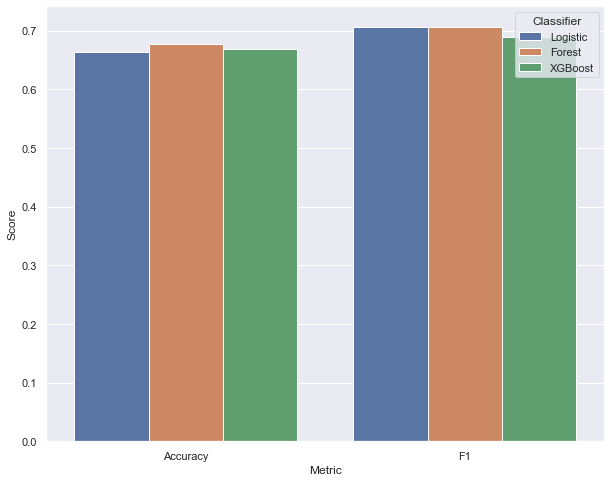

In [17]:
sns.set(rc={'figure.figsize':(10,8)})

results = pd.DataFrame()
results = results.append([{'Classifier':'Logistic','Score':0.663,'Metric':'Accuracy'},
                        {'Classifier':'Logistic','Score':0.706,'Metric':'F1'},
                        {'Classifier':'Forest','Score':0.677,'Metric':'Accuracy'},
                        {'Classifier':'Forest','Score':0.706,'Metric':'F1'},
                        {'Classifier':'XGBoost','Score':0.669,'Metric':'Accuracy'},
                        {'Classifier':'XGBoost','Score':0.690,'Metric':'F1'}])


stx = sns.barplot(x='Metric',y='Score',hue='Classifier',data=results)

As a final test, I evaluate the Logistic Regression and Random Forest models on the GME cascade data, training the models on both the original train data and test data.

In [133]:
for i in range(5):
    X_train = train_forest_features_list[i].iloc[:,:-1]
    y_train = train_forest_features_list[i].iloc[:,-1]
    X_test = test_forest_features_list[i].iloc[:,:-1]
    y_test = test_forest_features_list[i].iloc[:,-1]
    
    X_train_all = X_train.append(X_test)
    y_train_all = y_train.append(y_test)
    
    logreg = make_pipeline(StandardScaler(),LogisticRegression(C=1))
    logreg.fit(X_train_all,y_train_all)
    gme_pred = logreg.predict(gme_features.iloc[:,:-1])
    
    print('gme score: ')
    print(accuracy_score(gme_features.iloc[:,-1],gme_pred))
    print('f1 score: ')
    print(f1_score(gme_features.iloc[:,-1],gme_pred))
    
    

gme score: 
0.6
f1 score: 
0.7241379310344828
gme score: 
0.6
f1 score: 
0.7241379310344828
gme score: 
0.6
f1 score: 
0.7241379310344828
gme score: 
0.6
f1 score: 
0.7241379310344828
gme score: 
0.6
f1 score: 
0.7241379310344828


In [137]:
for i in range(5):
    X_train = train_forest_features_list[i].iloc[:,:-1]
    y_train = train_forest_features_list[i].iloc[:,-1]
    X_test = test_forest_features_list[i].iloc[:,:-1]
    y_test = test_forest_features_list[i].iloc[:,-1]
    
    X_train_all = X_train.append(X_test)
    y_train_all = y_train.append(y_test)
    
    rf = RandomForestClassifier(n_estimators=50,max_depth=4)
    rf.fit(X_train_all,y_train_all)
    gme_pred = rf.predict(gme_features.iloc[:,:-1])
    
    print('gme score: ')
    print(accuracy_score(gme_features.iloc[:,-1],gme_pred))
    print('f1 score: ')
    print(f1_score(gme_features.iloc[:,-1],gme_pred))

gme score: 
0.25
f1 score: 
0.03225806451612903
gme score: 
0.2625
f1 score: 
0.06349206349206349
gme score: 
0.25
f1 score: 
0.03225806451612903
gme score: 
0.2625
f1 score: 
0.06349206349206349
gme score: 
0.2625
f1 score: 
0.06349206349206349


Rather disappointingly, the Logistic Regression model performs notably worse than on the other test data, and the Random Forest performs abysmally. I was hopeful that there would be enough similarity in temporal structure bwteen large cascades and the huge GME cascade, but perhaps this was a naive assumption. The GME cascade will naturally have a more complex pattern, as it consists of thousands of post-comment trees.

In conclusion, while this did not come up with the result I would ideally like to have achieved, the predictions on the rest of the data were reasonably good, at around 70% F1 score for both tree data and forest data. There are many more explorations that could be made into this topic, including incorporating more temporal features, restructuring the testing process to allow for the incorporation of other features, and perhaps most importantly, gathering more cascade forest data. Since I was exclusively using temporal features in my analysis, the model could in theory be trained on any reddit cascades, and this logic would also apply to structural features.

One reason why I disregarded user-specific features in this analysis is that reddit has a much larger degree of anonymity than twitter or other social networks: while there definitely popular content creators, there is much less of a 'celebrity' culture on the site. Additionally, there is no way (to my knowledge) to extract the number of followers for a specific reddit user.

This has also been a valuable process for me, in which I have become familiar with a number of new tools, and got the opportunity to explore an interesting topic.